# Winner-take-all threshold networks

Tse et al. 2010

## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import pandas as pd
import copy

# import custom functions
from corrmat_functions import *

## Utility function definition

In [2]:
# ---- from denois_and_mst

def print_tns(msts, n_cols=4):
    T = len(msts.keys())

    # dimensions of figure/plot grid
    n_cols = 4
    n_rows = int(np.ceil(T/n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4), constrained_layout=True)
    for cnt,timestamp in enumerate(sorted(msts.keys())):
        # determine axis
        col = cnt % n_cols
        row = cnt // n_cols
        ax = axs[row, col]

        # plot mst
        mst = msts[timestamp]

        node_color = [nx.degree(mst)[n] for n in nx.nodes(mst)]
        node_size = [200 + nx.degree(mst)[n] * 10 for n in nx.nodes(mst)]
#         pos = nx.kamada_kawai_layout(mst)
#         pos = nx.spring_layout(mst, k=0.1)
#         pos=nx.fruchterman_reingold_layout(mst)
        pos=nx.circular_layout(mst)
        nx.draw(mst, pos, ax=ax, node_color=node_color, cmap='Oranges', labels=nx.get_node_attributes(mst, 'ticker'), with_labels=True, node_size=node_size, font_size=6)
        ax.set_title(timestamp)
        fig.suptitle("TNs over time")
    
    # turn off extra axe
    for i in range(max(enumerate(sorted(threshold_networks.keys())))[0] + 1, n_cols * n_rows):
        col = i % n_cols
        row = i // n_cols
        ax = axs[row, col]
        ax.axis('off')

## Data Preparation

In [3]:
# load corr matrices and tickers
corrmats = load_all_corrmats() # load correlation matrices
tickers = load_corrmat_tickers() # load tickers
denoised_notnull_corrmats = np.load('data/denoised_notnull_corrmats.npy', allow_pickle='TRUE').item() # load denoised correlation matrices

## Construction of Threshold networks

In [4]:
# generate a filtered network given a corr matrix and a threshold
def threshold_network(corr_org, threshold, tics = None):
    corr = np.copy(corr_org)
    np.fill_diagonal(corr, 0) # set diagonal elements to 0, to avoid self loops
    filtered_corr = np.ma.masked_where(corr < threshold, corr).filled(fill_value=0) # filter corr matrix w/ given threshold
    g = nx.from_numpy_matrix(filtered_corr) # construct network from numpy array
    
    #creating dictionary with index as keys to set node attributes
    if tics is not None:
        tickers = {index: ticker for index, ticker in enumerate(tics)}
        nx.set_node_attributes(g, tickers , 'ticker')
#         nx.get_node_attributes(g, 'ticker')
    return g


# find the minimum and maximum threholds
# minimum threshold = the maximum threshold preserves the number of connected components
# maximum threhold = the largest correlation of a given corr matrix
def min_max_threshold_finder(corr_org, func = nx.number_connected_components):
    corr = np.copy(corr_org) # make a deep copy of the original corr matrix
    np.fill_diagonal(corr, 0) # set diagonal elements to 0, to avoid self loops
    benchmark_g = threshold_network(corr, 0) # construct a benchmark network w/o filtering
    
    num_connected_comp = func(benchmark_g) # number of connected components of the unfiltered network

    max_threshold = np.max(corr) # max threshold = largest corr of all pairs
    
    min_threshold = min_threshold_finder(corr, num_connected_comp, max_threshold, func = func) # calculate the min threshold, which
                                                                            # is the maximum correlation that
                                                                            # preserves a graph as connected as the original
                                                                            # w/ the same num_connected_nodes
    

    
    return min_threshold, max_threshold

# given corr matrix, max_threshold, guessed_min_threhold, find the min_thereshold by binary search
def min_threshold_finder(corr, num_connected_comp, max_threshold, min_guessed = 0, conv_limit = 0.0001, func = nx.number_connected_components):
    # base case
    if abs(max_threshold - min_guessed) < conv_limit:
        return min_guessed
    
    # recursive logic
    curr_threshold = (max_threshold + min_guessed) / 2  # take mean of given max and min as current threshold
    filtered_corr = np.ma.masked_where(corr < curr_threshold, corr).filled(fill_value=0) # filter the corr matrix by the current threshold
    g = nx.from_numpy_matrix(filtered_corr) # construct a network
    ncc_temp = func(g) # number of connected component (NCC) of current network
    g = [] # optimizer memory usage
    
    if ncc_temp > num_connected_comp: # if curr_threshold does not preserve NCC, it upper-bounds the min_threhold
        return min_threshold_finder(corr, num_connected_comp, curr_threshold, min_guessed)
    elif abs(curr_threshold - max_threshold) > conv_limit: # if curr_threshold preserves NCC, but is not accurate enough, it lower-bounds NCC
        return min_threshold_finder(corr, num_connected_comp, max_threshold, curr_threshold)
    else: # if curr_threshold preserves NCC and is accurate enough (within a neighboring interval of conv_limit)
        return curr_threshold 

In [5]:
#creating dictionary of threshold networks based on denoised non null correlation matrices
#dictionary structure :
# { <timestamp> : <threshold_network>}


fractional_threshold = 0.7 # hard-imposed threshold w.r.t. min-max thresholds, i.e. t = min + t * (max - min)
threshold_networks = {} # instantiate a dict for threshold networks
min_max = []
thresholds_list = []
for k, v in denoised_notnull_corrmats.items():
    corr = v['corrmat']
    tics = v['tickers']
    
    min_threshold, max_threshold = min_max_threshold_finder(corr) # by default, to preserve the number of connected component
    min_max.append([min_threshold, max_threshold]) # keep a record of min, max thresholds
#     min_threshold, max_threshold = min_max_threshold_finder(corr, func = lambda g: sum(np.array(g.degree)[:, 1] != 0)) # to preserve the number of nodes w/ non-zero dgr

    threshold_temp = min_threshold + (max_threshold - min_threshold) * fractional_threshold
    
    threshold_networks[k] = threshold_network(corr, threshold_temp, tics)
    

## Visual inspection

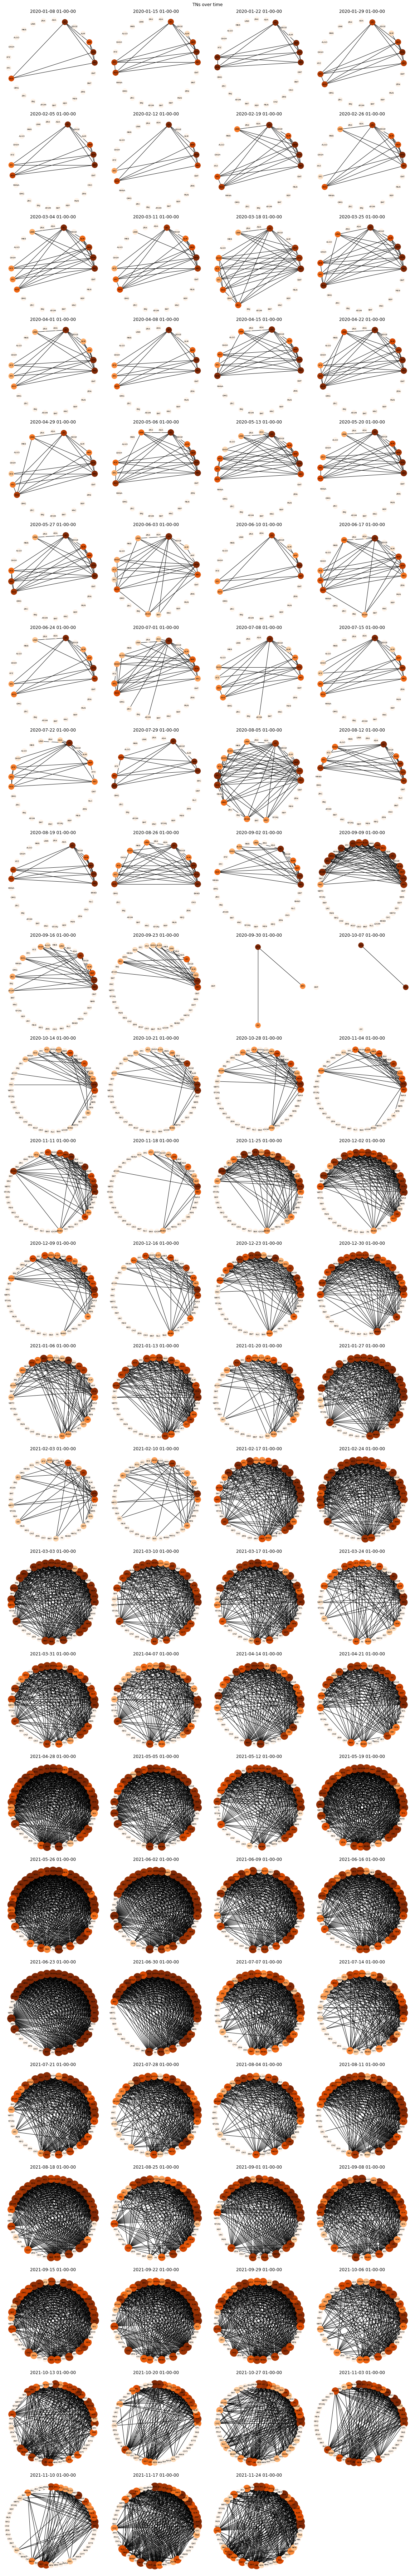

In [6]:
print_tns(threshold_networks)

In [7]:
#saving threshold network dictionaries to file

np.save('data/tns.npy', threshold_networks)

## Visualization of some sample threshold networks

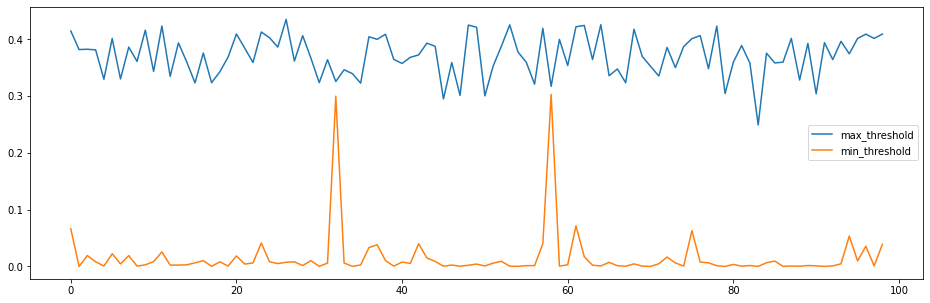

In [8]:
min_max = np.array(min_max)
fig, ax = plt.subplots(1, 1, figsize = (16, 5))
ax.plot(min_max[:, 1], label = 'max_threshold')
ax.plot(min_max[:, 0], label = 'min_threshold')
ax.legend()
# ax.set_ylim(0, 0.003)

## Network property calculation

In [9]:
measure_m = [] # initiate a matrix for network measures, including,
                        # [weighted_avg_clustering_coefficient, weighted_avg_dgr]
measure_names = ['weighted_avg_clustering_coefficient', 'weighted_avg_dgr']
ts_list = []
for ts in sorted(threshold_networks.keys()):
    # load network
    g = threshold_networks[ts]
    # calculate measures
#     dia = nx.diameter(g) # infinite diameter for disconnected networks
#     avg_sp = nx.average_shortest_path_length(g, weight = 'weight') # no definition for disconnected network
    avg_clu = nx.average_clustering(g, weight = 'weight')
    dgr_list = [weighted_dgr for _, weighted_dgr in g.degree(weight = 'weight')]
    avg_dgr = sum(dgr_list) / len(dgr_list)
    measure_m.append([avg_clu, avg_dgr])
    ts_list.append(ts)
    
measure_m = np.array(measure_m)

array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

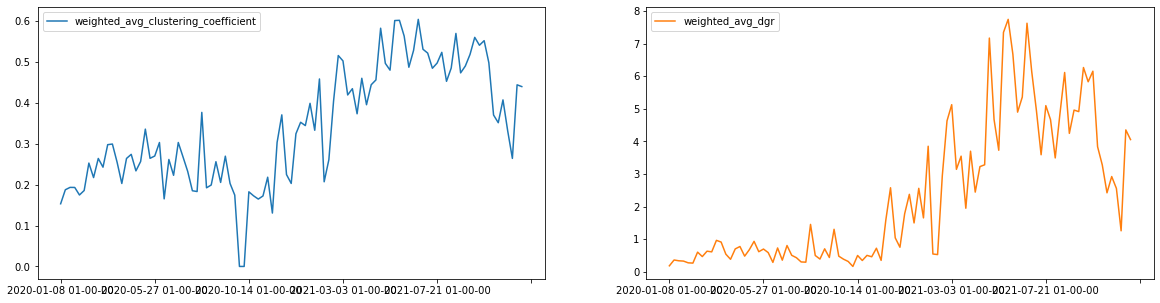

In [10]:
# pack measures in a pd.dataframe
measure_df = pd.DataFrame(data=measure_m, index=ts_list, columns=measure_names)
measure_df.plot(subplots = True, figsize = (20, 5), layout = (1, 2))